# Predcition of Hospital Admission Related to Cough

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to cough. We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [14]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [15]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [16]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [17]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'cough_date_'+str(i), 'cough_ab_date_'+str(i), 'cough_ab_type_'+str(i),
                   'incdt_cough_date_'+str(i), 'admitted_cough_date_'+str(i), 'sgss_gp_cov_cough_date_'+str(i)]]
    
    #drop rows with no cough reord
    datum = datum[datum['cough_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with cough_i
    datum = datum[datum['sgss_gp_cov_cough_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'cough_date_'+str(i): 'cough_date', 'cough_ab_date_'+str(i): 'cough_ab_date', 
                           'cough_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_cough_date_'+str(i): 'incdt_cough_date', 'incdt_cough_type_'+str(i): 'incdt_cough_type',
                           'admitted_cough_date_'+str(i): 'admitted_cough_date',
                           'sgss_gp_cov_cough_date_'+str(i): 'sgss_gp_cov_cough_date'},
                inplace=True)
    
    return datum

In [18]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req_enc

In [19]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [20]:
def cox_build(infection, infection_type, data, data_no_abs): #data_cough_incdt, data_cough_no_abs_incdt
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_cough_admitted',
            event_col='event_cough_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_cough_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a column for prescribed antibiotics
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_cough_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [21]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)#, random_state=42)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [22]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)#, random_state=42)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [23]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [24]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough.csv.gz')

In [25]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [26]:
#process 20 coughs and concatenate them 
data_cough_1 = proc_infec_data(data,1)
data_cough_2 = proc_infec_data(data,2)
data_cough_3 = proc_infec_data(data,3)
data_cough_4 = proc_infec_data(data,4)
data_cough_5 = proc_infec_data(data,5)
data_cough_6 = proc_infec_data(data,6)
data_cough_7 = proc_infec_data(data,7)
data_cough_8 = proc_infec_data(data,8)
data_cough_9 = proc_infec_data(data,9)
data_cough_10 = proc_infec_data(data,10)
data_cough_11 = proc_infec_data(data,11)
data_cough_12 = proc_infec_data(data,12)
data_cough_13 = proc_infec_data(data,13)
data_cough_14 = proc_infec_data(data,14)
data_cough_15 = proc_infec_data(data,15)
data_cough_16 = proc_infec_data(data,16)
data_cough_17 = proc_infec_data(data,17)
data_cough_18 = proc_infec_data(data,18)
data_cough_19 = proc_infec_data(data,19)
data_cough_20 = proc_infec_data(data,20)

data_cough = pd.concat([data_cough_1, data_cough_2, data_cough_3, data_cough_4, data_cough_5, data_cough_6, data_cough_7, data_cough_8, data_cough_9, data_cough_10, data_cough_11, data_cough_12, data_cough_13, data_cough_14, data_cough_15, data_cough_16, data_cough_17, data_cough_18, data_cough_19, data_cough_20])
data_cough.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [27]:
##add variable season
#convert data types
data_cough['cough_date'] = data_cough['cough_date'].astype('datetime64[ns]')
data_cough['admitted_cough_date'] = data_cough['admitted_cough_date'].astype('datetime64[ns]')
data_cough.died_date = data_cough.died_date.astype('datetime64[ns]')
data_cough.deregistered_date = data_cough.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_cough['date'] = data_cough['cough_date'] 
data_cough['date'] = data_cough['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_cough with today's date in year and month
data_cough = data_cough[data_cough['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_cough = data_cough[data_cough['date'] != last_1_month_date_y_m]
data_cough = data_cough[data_cough['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of cough records
data_cough['season'] = np.nan
data_cough['date_month'] = pd.DatetimeIndex(data_cough['date']).month

conditions = [
    (data_cough['date_month'] >= 3) & (data_cough['date_month'] <= 5),
    (data_cough['date_month'] >= 6) & (data_cough['date_month'] <= 8),
    (data_cough['date_month'] >= 9) & (data_cough['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_cough['season'] = np.select(conditions, choices, default='winter')

In [28]:
#add variable time period
data_cough.loc[(data_cough['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_cough.loc[((data_cough['date'] >= '2020-01') & (data_cough['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_cough.loc[(data_cough['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [29]:
data_cough['date'].max()

'2023-02'

#### event and duration

In [30]:
#scenario 1
#not hosped (nothing happened)
data_cough.loc[data_cough['admitted_cough_date'].isnull(), 'event_cough_admitted'] = 0

In [31]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_cough['delta_cough_admitted'] = (data_cough['admitted_cough_date'] - data_cough['cough_date']).dt.days
data_cough.loc[((data_cough['delta_cough_admitted'] >= 0) & (data_cough['delta_cough_admitted'] <= 30)), 'event_cough_admitted'] = 1

#scenario 2
#drop whoever was admitted before cough consultation, i.e. negative value for delta_cough_admitted
data_cough = data_cough[~(data_cough['delta_cough_admitted'] < 0)]

In [32]:
#scenario 3
#censor died patients
data_cough['delta_admitted_died'] = (data_cough['died_date'] - data_cough['admitted_cough_date']).dt.days
data_cough.loc[data_cough['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_cough.loc[((data_cough['delta_admitted_died'] >= 0) & (data_cough['delta_admitted_died'] <= 30)), 'event_cough_admitted'] = 0

#scenario 3
#censor deregistered patients
data_cough['delta_admitted_deregistered'] = (data_cough['deregistered_date'] - data_cough['admitted_cough_date']).dt.days
data_cough.loc[data_cough['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_cough.loc[((data_cough['delta_admitted_deregistered'] > 0) & (data_cough['delta_admitted_deregistered'] <= 30)), 'event_cough_admitted'] = 0

#agg scenario 3s
data_cough['delta_admitted_died_deregistered'] = data_cough['delta_admitted_deregistered'].combine_first(data_cough['delta_admitted_died'])
data_cough.loc[data_cough['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [33]:
#scenario 1
#any other patients (nothing happened)
data_cough['event_cough_admitted'] = data_cough['event_cough_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_cough['duration_cough_admitted'] = data_cough['delta_cough_admitted'].combine_first(data_cough['delta_admitted_died_deregistered'])
data_cough['duration_cough_admitted'] = data_cough['duration_cough_admitted'].replace(np.NaN, 30)
data_cough.loc[(data_cough['duration_cough_admitted'] > 30), 'duration_cough_admitted'] = 30

#give value 1 to event_cough_admitted if duration_cough_admitted is greater or equal to 0 and less than 30
data_cough.loc[((data_cough['duration_cough_admitted'] >= 0) & (data_cough['duration_cough_admitted'] < 30)), 'event_cough_admitted'] = 1

#drop any rows with value 0 in duration column
data_cough = data_cough[~(data_cough['duration_cough_admitted'] == 0)]

In [34]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_cough.loc[((data_cough['delta_cough_admitted'] > 0) & (data_cough['delta_cough_admitted'] < 30)), 'event_cough_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [35]:
#drop anybody with age less than 18 or 0!
data_cough = data_cough[~(data_cough['age'] < 18)] 
data_cough['age'][data_cough['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_cough = data_cough[data_cough['age_cat'] != '0-4']
data_cough = data_cough[data_cough['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_cough['bmi'][data_cough['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_cough['bmi'] = data_cough['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_cough['antibacterial_brit'][data_cough['antibacterial_brit'] < 0] = np.nan

In [36]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_cough = data_cough.replace({"sex": dict_sex})
data_cough = data_cough.replace({"smoking": dict_smoking})

In [37]:
#drop rows with missing region
if ('region' in data_cough.columns) and (data_cough['region'].isnull().sum() > 0):
   data_cough = data_cough[data_cough['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_cough.columns) and (data_cough['antibacterial_brit'].isnull().sum() > 0):
    data_cough['antibacterial_brit'] = data_cough['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_cough.columns) and (data_cough['ethnicity'].isnull().sum() > 0):
    data_cough['ethnicity'] = data_cough['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_cough.columns) and (data_cough['smoking'].isnull().sum() > 0):
    data_cough['smoking'] = data_cough['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_cough.columns) and (data_cough['imd'].isnull().sum() > 0):
    data_cough['imd'] = data_cough['imd'].fillna(0)

In [38]:
#missing values of bmi assign 5 and 0; categorise bmi
data_cough['bmi_cat'] = 5

for idx, x in enumerate(data_cough['bmi_cat']):
    if data_cough.iat[idx, data_cough.columns.get_loc('bmi')] >= 30:
        data_cough.iat[idx, data_cough.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_cough.iat[idx, data_cough.columns.get_loc('bmi')] >= 25) and (data_cough.iat[idx, data_cough.columns.get_loc('bmi')] < 30):
        data_cough.iat[idx, data_cough.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_cough.iat[idx, data_cough.columns.get_loc('bmi')] >= 18.5) and (data_cough.iat[idx, data_cough.columns.get_loc('bmi')] < 25):
        data_cough.iat[idx, data_cough.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_cough.iat[idx, data_cough.columns.get_loc('bmi')] < 18.5:
        data_cough.iat[idx, data_cough.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_cough.columns) and (data_cough['bmi_cat'].isnull().sum() > 0):
    data_cough['bmi_cat'] = data_cough['bmi_cat'].fillna(0)

In [39]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_cough.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_cough['ab_type_cat'] = np.where(data_cough['ab_type'].isin(ab_series[mask].index),'other',data_cough['ab_type'])
#assign no to non ab users
data_cough.loc[data_cough['cough_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_cough['ab_type_cat'] = data_cough['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [40]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_cough = data_cough.replace({"sex": dict_sex})
data_cough = data_cough.replace({"ethnicity": dict_ethnicity})
data_cough = data_cough.replace({"smoking": dict_smoking})
data_cough = data_cough.replace({"imd": dict_imd})
data_cough = data_cough.replace({"bmi_cat": dict_bmi})
data_cough = data_cough.replace({"flu_vaccine": dict_flu})
data_cough = data_cough.replace({"region": dict_region})
data_cough = data_cough.replace({"age_cat": dict_age})
data_cough = data_cough.replace({"ab_type_cat": dict_ab_type})

In [41]:
data_cough.ethnicity.value_counts('NA')

white      0.600719
unknown    0.250071
asian      0.074766
other      0.074443
Name: ethnicity, dtype: float64

In [42]:
data_cough.smoking.value_counts('NA')

unknown         0.416279
smoker          0.390566
never_smoked    0.128797
ex_smoker       0.064358
Name: smoking_status, dtype: float64

In [43]:
data_cough.bmi_cat.value_counts('NA')

obese             0.519298
unknown           0.254844
overweight        0.112608
healthy_weight    0.081486
underweight       0.031764
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [44]:
#categorise CCI
data_cough['CCI_cat'] = pd.cut(data_cough['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_cough['antibacterial_brit'].clip(0, data_cough['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

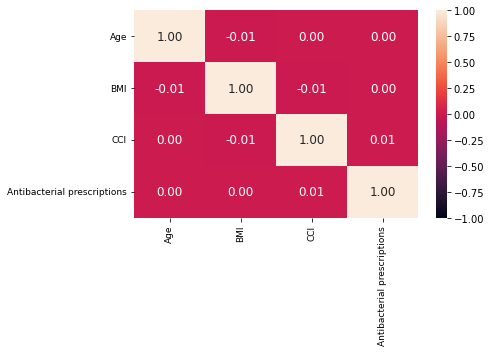

In [45]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_cough[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_cough/corr_cough.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [46]:
data_cough = data_cough[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'cough_ab_date', 'ab_type_cat', 'incdt_cough_date', 'date', 'period',
                                   'event_cough_admitted', 'duration_cough_admitted'
                                    ]]

In [47]:
#switch variable cough_ab_date into a binary variable
data_cough[['ab_binary']] = data_cough[['cough_ab_date']].where(data_cough[['cough_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_cough_incdt = data_cough[data_cough['incdt_cough_date'] == 0]
data_cough_prevl = data_cough[data_cough['incdt_cough_date'] == 1]

#no antibiotics and incident hospital admission
data_cough_no_abs_incdt = data_cough_incdt[data_cough_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_cough_abs_incdt = data_cough_incdt[data_cough_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_cough_no_abs_prevl = data_cough_prevl[data_cough_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_cough_abs_prevl = data_cough_prevl[data_cough_prevl['ab_binary'] == 1]

In [48]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_cough_incdt_prepandemic = data_cough_incdt[data_cough_incdt['period'] == 'prepandemic']
data_cough_incdt_during_pandemic = data_cough_incdt[(data_cough_incdt['period'] == 'during_pandemic')]
data_cough_incdt_post_2nd_lockdown = data_cough_incdt[data_cough_incdt['period'] == 'post_2nd_lockdown']
data_cough_prevl_prepandemic = data_cough_prevl[data_cough_prevl['period'] == 'prepandemic']
data_cough_prevl_during_pandemic = data_cough_prevl[(data_cough_prevl['period'] == 'during_pandemic')]
data_cough_prevl_post_2nd_lockdown = data_cough_prevl[data_cough_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_cough_no_abs_incdt_prepandemic = data_cough_incdt_prepandemic[data_cough_incdt_prepandemic['ab_binary'] == 0]
data_cough_no_abs_incdt_during_pandemic = data_cough_incdt_during_pandemic[data_cough_incdt_during_pandemic['ab_binary'] == 0]
data_cough_no_abs_incdt_post_2nd_lockdown = data_cough_incdt_post_2nd_lockdown[data_cough_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_cough_no_abs_prevl_prepandemic = data_cough_prevl_prepandemic[data_cough_prevl_prepandemic['ab_binary'] == 0]
data_cough_no_abs_prevl_during_pandemic = data_cough_prevl_during_pandemic[data_cough_prevl_during_pandemic['ab_binary'] == 0]
data_cough_no_abs_prevl_post_2nd_lockdown = data_cough_prevl_post_2nd_lockdown[data_cough_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [49]:
#store data for plotting hosp admission counts and percentages
%store data_cough
# save data
data_cough.to_csv('../output/hospitalisation_prediction_cough/data_cough.csv')

Stored 'data_cough' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-1- incident

<lifelines.CoxPHFitter: fitted with 112561 total observations, 111754 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 112561
number of events observed = 807
   partial log-likelihood = -9367.13
         time fit was run = 2023-06-28 22:21:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.00       1.00       0.11            -0.21             0.21                 0.81                 1.23
CCI_cat[T.medium]                0.01       1.01       0.12            -0.22             0.24                 0.80                 1.27
CCI_cat[T.high]                  0.01       1.01       0.14            -0.27             0.28                 0.77                 1.33
CCI_cat[T.very_high]             0.15       1.16       0.12            -0.08             0.38                 0.92                 1.46
age_cat[T.25_34]                 0.02       1.02       0.13            -0.23             0.27                 0.79                 1.31
age_cat[T.35_44]                -0.11       0.90       0.13            -0.37             0.15                 0.69                 1.16
age_cat[T.45_54]                -0.14       0.87       0.13            -0.40             0.13                 0.67                 1.13
age_cat[T.55_64]                 0.11       1.11       0.13            -0.14             0.36                 0.87                 1.43
age_cat[T.65_74]                -0.00       1.00       0.13            -0.25             0.25                 0.78                 1.29
age_cat[T.75_more]              -0.19       0.83       0.14            -0.45             0.08                 0.63                 1.08
antibacterial_brit               0.05       1.05       0.02            -0.00             0.09                 1.00                 1.10
bmi_cat[T.obese]                -0.07       0.93       0.13            -0.32             0.19                 0.73                 1.20
bmi_cat[T.overweight]            0.05       1.05       0.16            -0.26             0.35                 0.77                 1.42
bmi_cat[T.underweight]          -0.36       0.70       0.26            -0.87             0.15                 0.42                 1.16
bmi_cat[T.unknown]              -0.09       0.92       0.14            -0.36             0.18                 0.70                 1.20
ethnicity[T.other]              -0.15       0.86       0.18            -0.50             0.21                 0.61                 1.23
ethnicity[T.unknown]            -0.09       0.91       0.14            -0.37             0.18                 0.69                 1.20
ethnicity[T.white]              -0.09       0.91       0.13            -0.35             0.17                 0.71                 1.18
flu_vaccine[T.yes]              -0.02       0.98       0.12            -0.25             0.21                 0.78                 1.24
imd[T.medium]                    0.02       1.02       0.12            -0.22             0.25                 0.80                 1.29
imd[T.unaffluent]                0.26       1.30       0.11             0.04             0.48                 1.04                 1.62
imd[T.unknown]                   0.04       1.05       0.19            -0.32             0.41                 0.73                 1.50
imd[T.very_affluent]             0.03       1.03       0.12            -0.20             0.26                 0.82                 1.30
imd[T.very_unaffluent]           0.17       1.19       0.12            -0.05             0.40                 0.95                 1.49
region[T.east_midlands]         -0.05       0.95       0.16    

12222


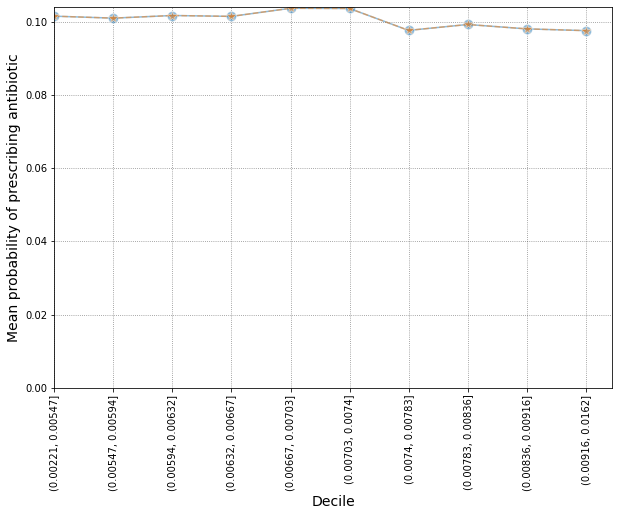


AUROC of LR for deciles with development and validation data: 0.50660 and 0.50533
AUROC of RF for deciles with development and validation data: 0.51792 and 0.50737
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00221, 0.00547]  0.114766  0.108291  0.121627
bins_(0.00547, 0.00594]  0.114554  0.108040  0.121462
bins_(0.00594, 0.00632]  0.113031  0.106508  0.119953
bins_(0.00632, 0.00667]  0.113740  0.107145  0.120740
bins_(0.00667, 0.00703]  0.115585  0.108892  0.122689
bins_(0.00703, 0.0074]   0.114944  0.108196  0.122112
bins_(0.0074, 0.00783]   0.108515  0.101966  0.115484
bins_(0.00783, 0.00836]  0.111326  0.104601  0.118483
bins_(0.00836, 0.00916]  0.110649  0.103868  0.117874
bins_(0.00916, 0.0162]   0.110143  0.103137  0.117626
antibacterial_brit       0.993186  0.979610  1.006950

RF feature importance:
                           rf_coef
antibacterial_brit       0.617229
bins_(0.0074, 0.00783]   0.046169
bins_(0.00836, 0.00916]  0.045806
bins_(0.

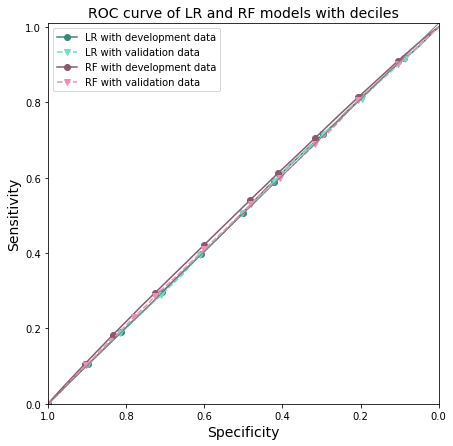

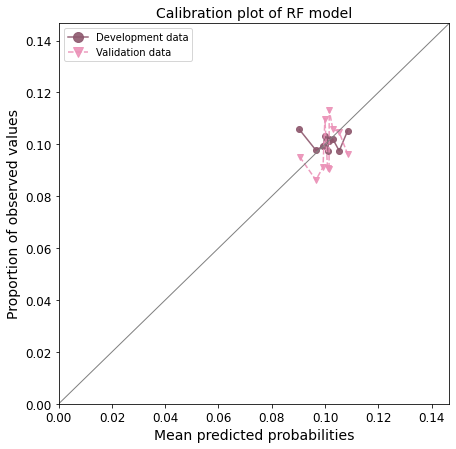

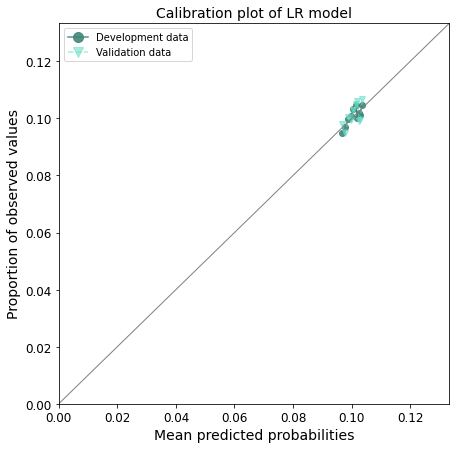


AUROC of LR for risk factors with development and validation data: 0.51894 and 0.50469
AUROC of RF for risk factors with development and validation data: 0.60704 and 0.50722
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.844697  0.000000       inf
age_cat_25_34                0.891624  0.000000       inf
age_cat_35_44                0.893930  0.000000       inf
age_cat_45_54                0.906189  0.000000       inf
age_cat_55_64                0.831431  0.000000       inf
age_cat_65_74                0.918871  0.000000       inf
age_cat_75_more              0.905891  0.000000       inf
sex_female                   0.650809  0.000000       inf
sex_male                     0.648795  0.000000       inf
CCI_cat_high                 0.808110  0.000000       inf
CCI_cat_low                  0.866314  0.000000       inf
CCI_cat_medium               0.873202  0.000000       inf
CCI_cat_very_high            0.832744  0.000000      

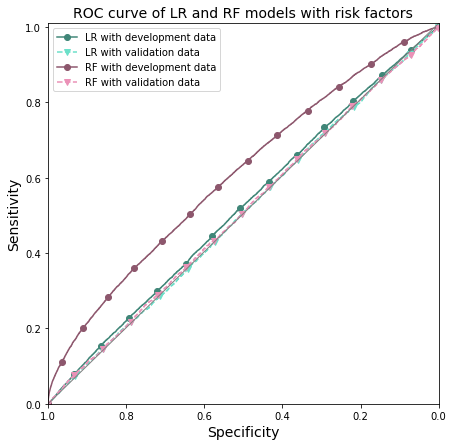

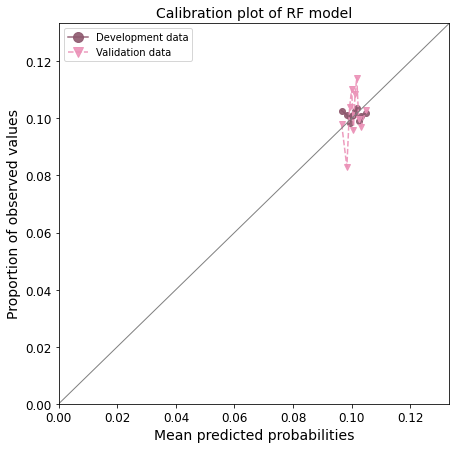

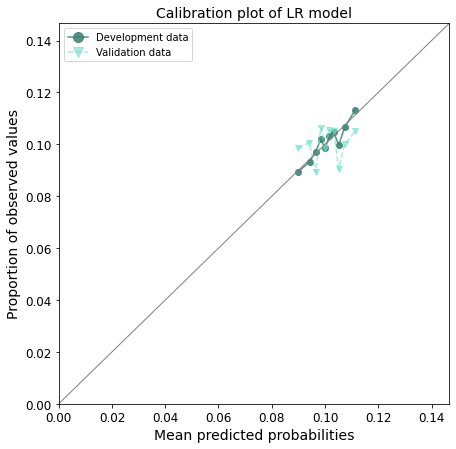

In [50]:
#build cox model for hosp prediction using non ab users' data
prob_pred_cough_no_abs_incdt, prob_pred_cough_no_abs_incdt_bin = cox_build('cough', 'incdt', data_cough_incdt, data_cough_no_abs_incdt)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_deciles('cough', 'incdt_deciles', prob_pred_cough_no_abs_incdt)

#make summary table
make_summary_table('cough', 'incdt', prob_pred_enc_lr_rf_incdt)

#calibration plots of rf and lr with deciles
calibration_rf_lr('cough', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_riskfactors('cough', 'incdt_riskfactors', prob_pred_cough_no_abs_incdt)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('cough', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 12530 total observations, 12431 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 12530
number of events observed = 99
   partial log-likelihood = -916.07
         time fit was run = 2023-06-28 22:22:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.46       1.58       0.33            -0.20             1.11                 0.82                 3.03
CCI_cat[T.medium]                0.35       1.42       0.36            -0.36             1.06                 0.70                 2.88
CCI_cat[T.high]                  0.31       1.36       0.43            -0.53             1.15                 0.59                 3.16
CCI_cat[T.very_high]             0.49       1.63       0.37            -0.24             1.21                 0.79                 3.36
age_cat[T.25_34]                 0.33       1.39       0.34            -0.33             0.99                 0.72                 2.68
age_cat[T.35_44]                -0.18       0.84       0.38            -0.92             0.56                 0.40                 1.76
age_cat[T.45_54]                -0.70       0.50       0.44            -1.55             0.16                 0.21                 1.18
age_cat[T.55_64]                -0.24       0.79       0.39            -1.00             0.52                 0.37                 1.68
age_cat[T.65_74]                -0.07       0.94       0.37            -0.78             0.65                 0.46                 1.92
age_cat[T.75_more]              -0.07       0.94       0.37            -0.80             0.66                 0.45                 1.94
antibacterial_brit               0.10       1.10       0.07            -0.04             0.23                 0.96                 1.26
bmi_cat[T.obese]                 0.10       1.11       0.38            -0.64             0.85                 0.53                 2.33
bmi_cat[T.overweight]           -0.31       0.73       0.50            -1.30             0.67                 0.27                 1.95
bmi_cat[T.underweight]           0.19       1.21       0.61            -1.02             1.39                 0.36                 4.02
bmi_cat[T.unknown]              -0.06       0.94       0.41            -0.87             0.74                 0.42                 2.10
ethnicity[T.other]               0.14       1.15       0.52            -0.88             1.16                 0.41                 3.18
ethnicity[T.unknown]             0.25       1.29       0.42            -0.57             1.08                 0.57                 2.95
ethnicity[T.white]              -0.04       0.96       0.40            -0.83             0.75                 0.43                 2.11
flu_vaccine[T.yes]               0.35       1.42       0.29            -0.21             0.92                 0.81                 2.51
imd[T.medium]                   -0.11       0.89       0.35            -0.81             0.58                 0.45                 1.79
imd[T.unaffluent]               -0.09       0.92       0.35            -0.77             0.60                 0.46                 1.82
imd[T.unknown]                   0.17       1.18       0.51            -0.83             1.16                 0.43                 3.20
imd[T.very_affluent]             0.46       1.58       0.31            -0.15             1.07                 0.86                 2.91
imd[T.very_unaffluent]           0.10       1.10       0.33            -0.56             0.75                 0.57                 2.12
region[T.east_midlands]         -0.07       0.93       0.39         

12222


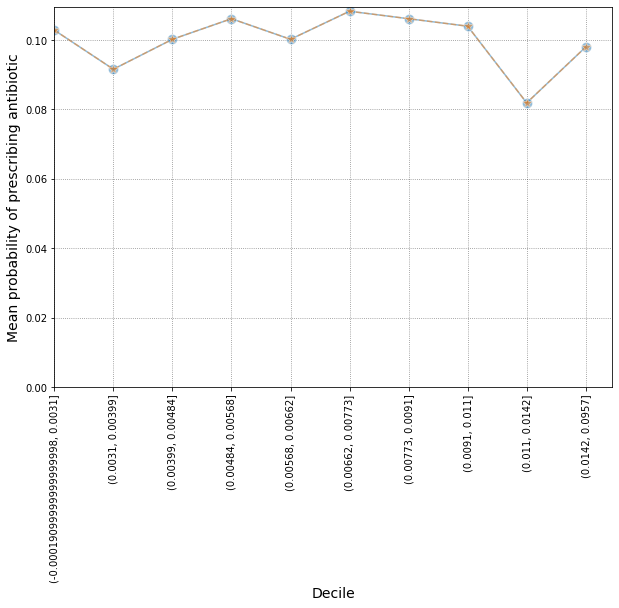


AUROC of LR for deciles with development and validation data: 0.53113 and 0.49090
AUROC of RF for deciles with development and validation data: 0.56200 and 0.50361
LR coefficients:
                                               OR  Lower CI  Upper CI
bins_(-0.00019099999999999998, 0.0031]  0.121503  0.102461  0.144083
bins_(0.0031, 0.00399]                  0.095953  0.079471  0.115853
bins_(0.00399, 0.00484]                 0.121983  0.102580  0.145055
bins_(0.00484, 0.00568]                 0.113635  0.095141  0.135724
bins_(0.00568, 0.00662]                 0.112304  0.093867  0.134362
bins_(0.00662, 0.00773]                 0.122211  0.102423  0.145821
bins_(0.00773, 0.0091]                  0.109365  0.091053  0.131361
bins_(0.0091, 0.011]                    0.114471  0.095599  0.137067
bins_(0.011, 0.0142]                    0.086559  0.070773  0.105865
bins_(0.0142, 0.0957]                   0.099318  0.081767  0.120637
antibacterial_brit                      1.017956  0.978433

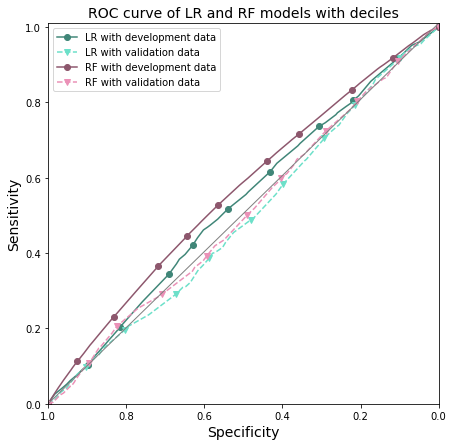

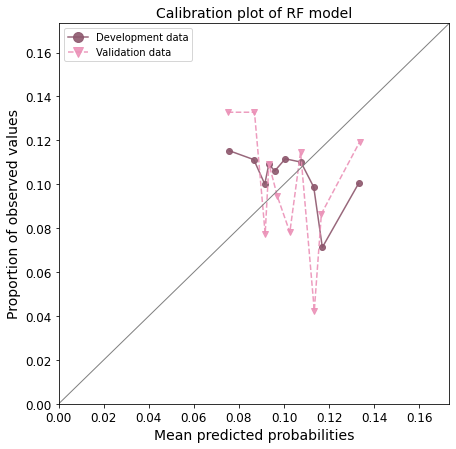

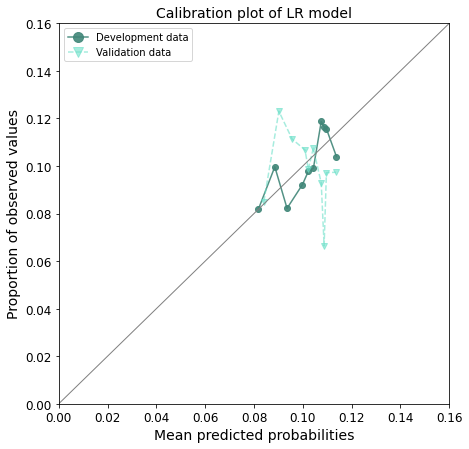


AUROC of LR for risk factors with development and validation data: 0.54699 and 0.51656
AUROC of RF for risk factors with development and validation data: 0.78997 and 0.51349
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_15_24                0.994379  0.000000       inf
age_cat_25_34                0.784063  0.000000       inf
age_cat_35_44                0.962154  0.000000       inf
age_cat_45_54                0.835132  0.000000       inf
age_cat_55_64                0.899942  0.000000       inf
age_cat_65_74                0.765246  0.000000       inf
age_cat_75_more              0.949830  0.000000       inf
sex_female                   0.640993  0.000000       inf
sex_male                     0.639310  0.000000       inf
CCI_cat_high                 0.861959  0.000000       inf
CCI_cat_low                  0.824484  0.000000       inf
CCI_cat_medium               0.812483  0.000000       inf
CCI_cat_very_high            0.897954  0.000000      

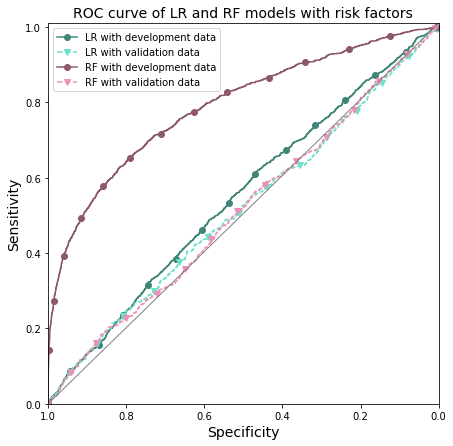

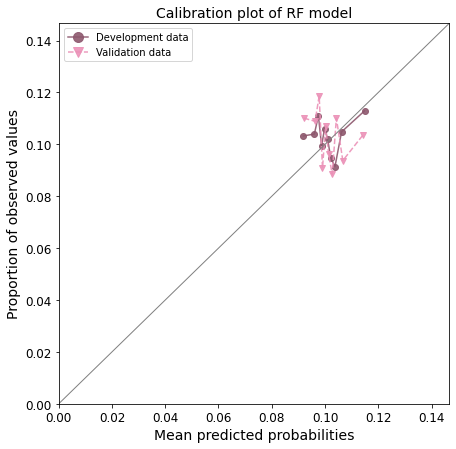

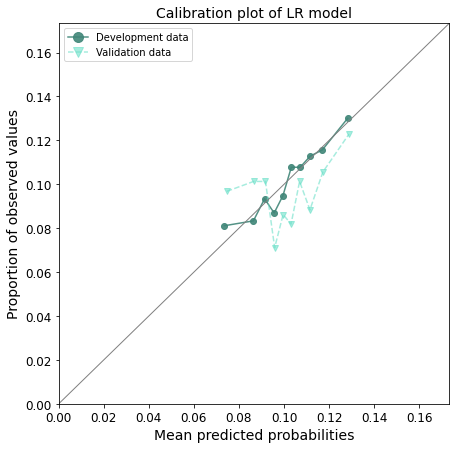

In [51]:
#build cox model for hosp prediction using non ab users' data
prob_pred_cough_no_abs_prevl, prob_pred_cough_no_abs_prevl_bin = cox_build('cough', 'prevl', data_cough_prevl, data_cough_no_abs_prevl)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_deciles('cough', 'prevl_deciles', prob_pred_cough_no_abs_prevl)

#make summary table
make_summary_table('cough', 'prevl', prob_pred_enc_lr_rf_prevl)

#calibration plots of rf and lr with deciles
calibration_rf_lr('cough', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_riskfactors('cough', 'prevl_riskfactors', prob_pred_cough_no_abs_prevl)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('cough', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 31014 total observations, 30813 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 31014
number of events observed = 201
   partial log-likelihood = -2055.01
         time fit was run = 2023-06-28 22:22:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.17       0.85       0.21            -0.57             0.24                 0.56                 1.27
CCI_cat[T.medium]               -0.22       0.80       0.24            -0.68             0.24                 0.51                 1.28
CCI_cat[T.high]                 -0.04       0.97       0.27            -0.57             0.50                 0.57                 1.64
CCI_cat[T.very_high]             0.12       1.13       0.23            -0.33             0.57                 0.72                 1.76
age_cat[T.25_34]                -0.29       0.75       0.25            -0.77             0.19                 0.46                 1.21
age_cat[T.35_44]                -0.12       0.89       0.23            -0.58             0.34                 0.56                 1.40
age_cat[T.45_54]                -0.86       0.42       0.29            -1.43            -0.29                 0.24                 0.75
age_cat[T.55_64]                -0.14       0.87       0.23            -0.60             0.32                 0.55                 1.38
age_cat[T.65_74]                -0.58       0.56       0.27            -1.10            -0.05                 0.33                 0.95
age_cat[T.75_more]              -0.45       0.64       0.26            -0.95             0.05                 0.39                 1.06
antibacterial_brit               0.04       1.05       0.05            -0.05             0.14                 0.95                 1.15
bmi_cat[T.obese]                -0.08       0.92       0.27            -0.61             0.45                 0.54                 1.57
bmi_cat[T.overweight]            0.40       1.49       0.30            -0.19             1.00                 0.82                 2.71
bmi_cat[T.underweight]          -0.43       0.65       0.56            -1.53             0.66                 0.22                 1.94
bmi_cat[T.unknown]               0.00       1.00       0.29            -0.56             0.56                 0.57                 1.76
ethnicity[T.other]              -0.61       0.55       0.38            -1.35             0.14                 0.26                 1.15
ethnicity[T.unknown]            -0.26       0.77       0.27            -0.79             0.26                 0.45                 1.30
ethnicity[T.white]              -0.27       0.77       0.25            -0.75             0.22                 0.47                 1.24
flu_vaccine[T.yes]              -0.06       0.94       0.24            -0.54             0.41                 0.59                 1.51
imd[T.medium]                    0.15       1.16       0.24            -0.32             0.62                 0.72                 1.86
imd[T.unaffluent]                0.19       1.21       0.24            -0.28             0.66                 0.76                 1.93
imd[T.unknown]                  -0.04       0.96       0.40            -0.82             0.73                 0.44                 2.08
imd[T.very_affluent]             0.30       1.35       0.23            -0.16             0.76                 0.86                 2.13
imd[T.very_unaffluent]           0.22       1.24       0.24            -0.25             0.68                 0.78                 1.98
region[T.east_midlands]         -0.53       0.59       0.35       

12232


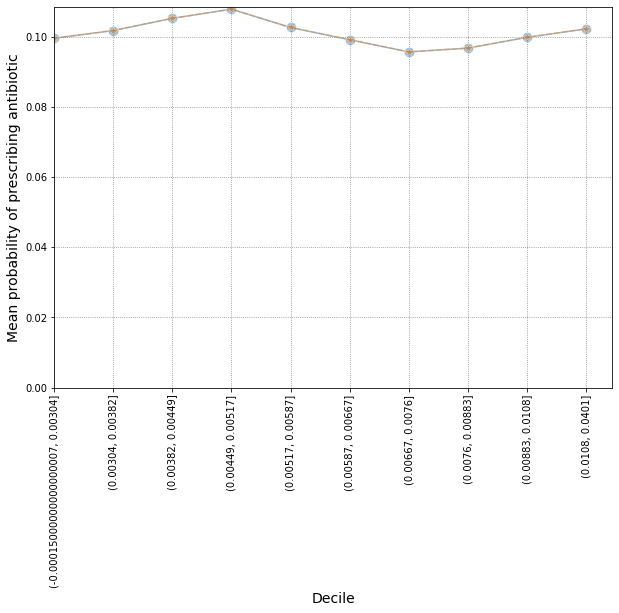


AUROC of LR for deciles with development and validation data: 0.51473 and 0.49318
AUROC of RF for deciles with development and validation data: 0.53350 and 0.49999
LR coefficients:
                                                OR  Lower CI  Upper CI
bins_(-0.00015000000000000007, 0.00304]  0.107722  0.095959  0.120927
bins_(0.00304, 0.00382]                  0.115926  0.103557  0.129772
bins_(0.00382, 0.00449]                  0.122829  0.110050  0.137092
bins_(0.00449, 0.00517]                  0.120433  0.107765  0.134590
bins_(0.00517, 0.00587]                  0.117349  0.104814  0.131382
bins_(0.00587, 0.00667]                  0.111787  0.099612  0.125450
bins_(0.00667, 0.0076]                   0.106728  0.094870  0.120069
bins_(0.0076, 0.00883]                   0.109221  0.097150  0.122791
bins_(0.00883, 0.0108]                   0.109273  0.097218  0.122822
bins_(0.0108, 0.0401]                    0.123418  0.110074  0.138378
antibacterial_brit                       0.9969

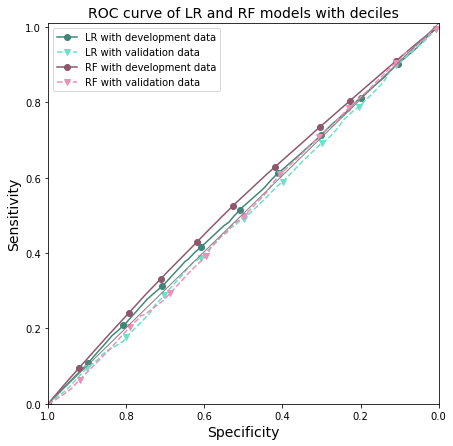

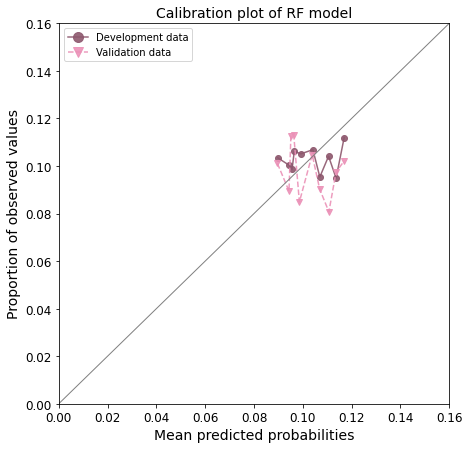

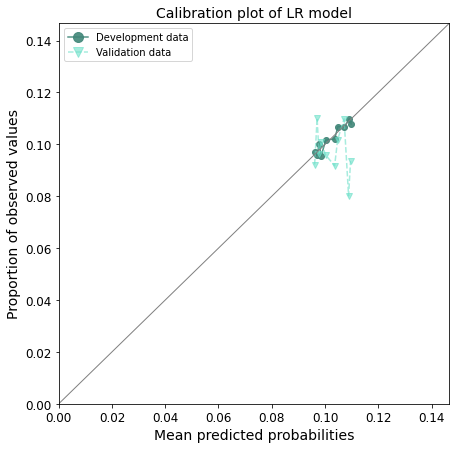

In [52]:
#build cox model for hosp prediction using non ab users' data
prob_pred_cough_no_abs_incdt_prepandemic, prob_pred_cough_no_abs_incdt_prepandemic_bin = cox_build('cough', 'incdt_prepandemic', data_cough_incdt_prepandemic, data_cough_no_abs_incdt_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('cough', 'incdt_prepandemic', prob_pred_cough_no_abs_incdt_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('cough', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)

<lifelines.CoxPHFitter: fitted with 35511 total observations, 35269 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 35511
number of events observed = 242
   partial log-likelihood = -2517.37
         time fit was run = 2023-06-28 22:22:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.02       1.02       0.20            -0.37             0.41                 0.69                 1.51
CCI_cat[T.medium]                0.12       1.13       0.22            -0.30             0.54                 0.74                 1.72
CCI_cat[T.high]                 -0.16       0.85       0.28            -0.71             0.38                 0.49                 1.46
CCI_cat[T.very_high]             0.32       1.38       0.22            -0.10             0.74                 0.90                 2.10
age_cat[T.25_34]                 0.20       1.22       0.24            -0.28             0.67                 0.75                 1.96
age_cat[T.35_44]                 0.20       1.22       0.24            -0.27             0.67                 0.76                 1.96
age_cat[T.45_54]                 0.02       1.02       0.25            -0.47             0.52                 0.62                 1.68
age_cat[T.55_64]                 0.26       1.30       0.24            -0.21             0.73                 0.81                 2.08
age_cat[T.65_74]                 0.10       1.11       0.25            -0.38             0.58                 0.68                 1.79
age_cat[T.75_more]              -0.09       0.92       0.26            -0.59             0.42                 0.55                 1.52
antibacterial_brit              -0.01       0.99       0.05            -0.10             0.08                 0.91                 1.08
bmi_cat[T.obese]                 0.12       1.12       0.24            -0.35             0.58                 0.70                 1.79
bmi_cat[T.overweight]           -0.21       0.81       0.31            -0.82             0.39                 0.44                 1.48
bmi_cat[T.underweight]          -0.26       0.77       0.47            -1.17             0.66                 0.31                 1.93
bmi_cat[T.unknown]              -0.14       0.87       0.26            -0.65             0.38                 0.52                 1.46
ethnicity[T.other]              -0.42       0.66       0.34            -1.09             0.25                 0.34                 1.29
ethnicity[T.unknown]            -0.15       0.86       0.25            -0.64             0.33                 0.53                 1.40
ethnicity[T.white]              -0.18       0.84       0.23            -0.63             0.27                 0.53                 1.31
flu_vaccine[T.yes]               0.01       1.01       0.22            -0.41             0.43                 0.66                 1.54
imd[T.medium]                   -0.29       0.75       0.21            -0.70             0.13                 0.49                 1.14
imd[T.unaffluent]               -0.11       0.89       0.20            -0.51             0.28                 0.60                 1.33
imd[T.unknown]                   0.07       1.07       0.30            -0.52             0.66                 0.59                 1.94
imd[T.very_affluent]            -0.34       0.71       0.22            -0.76             0.09                 0.47                 1.09
imd[T.very_unaffluent]           0.03       1.03       0.19            -0.35             0.41                 0.71                 1.51
region[T.east_midlands]          0.14       1.16       0.31       

12215


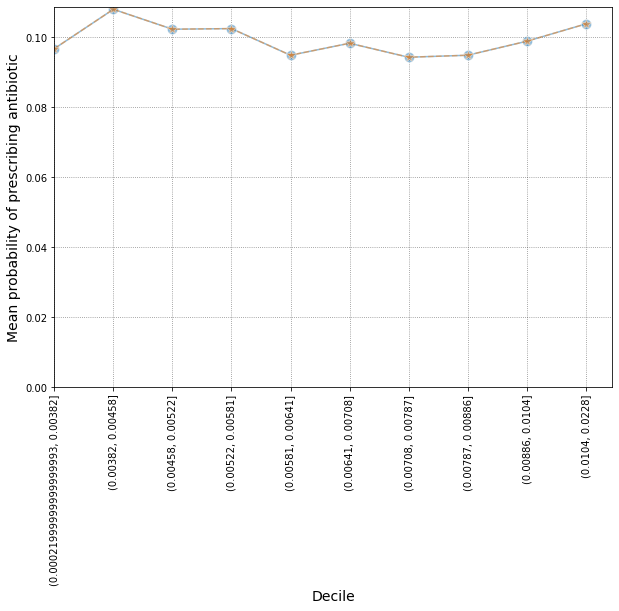


AUROC of LR for deciles with development and validation data: 0.51745 and 0.50981
AUROC of RF for deciles with development and validation data: 0.53580 and 0.51088
LR coefficients:
                                               OR  Lower CI  Upper CI
bins_(0.00021999999999999993, 0.00382]  0.114525  0.102803  0.127582
bins_(0.00382, 0.00458]                 0.121748  0.109467  0.135408
bins_(0.00458, 0.00522]                 0.117897  0.105970  0.131167
bins_(0.00522, 0.00581]                 0.111815  0.100259  0.124703
bins_(0.00581, 0.00641]                 0.107967  0.096706  0.120539
bins_(0.00641, 0.00708]                 0.112277  0.100798  0.125063
bins_(0.00708, 0.00787]                 0.109832  0.098446  0.122536
bins_(0.00787, 0.00886]                 0.104521  0.093502  0.116839
bins_(0.00886, 0.0104]                  0.118224  0.106302  0.131483
bins_(0.0104, 0.0228]                   0.113857  0.102197  0.126847
antibacterial_brit                      0.974389  0.951779

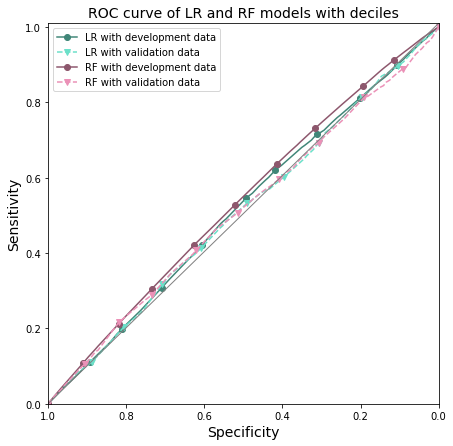

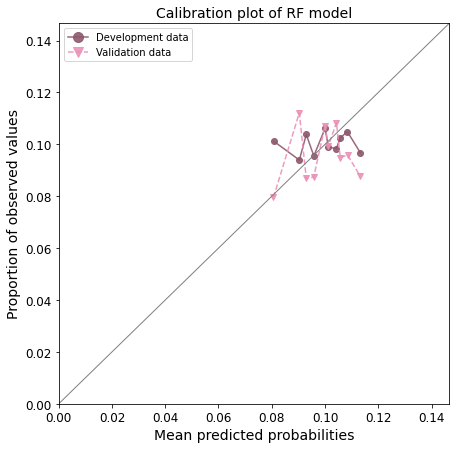

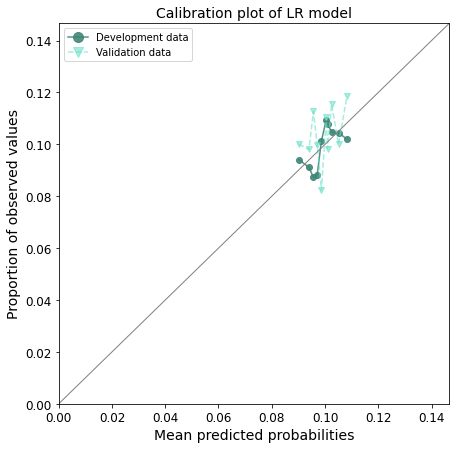

In [53]:
#build cox model for hosp prediction using non ab users' data
prob_pred_cough_no_abs_incdt_during_pandemic, prob_pred_cough_no_abs_incdt_during_pandemic_bin = cox_build('cough', 'incdt_during_pandemic', data_cough_incdt_during_pandemic, data_cough_no_abs_incdt_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('cough', 'incdt_during_pandemic', prob_pred_cough_no_abs_incdt_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('cough', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)

<lifelines.CoxPHFitter: fitted with 46035 total observations, 45688 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 46035
number of events observed = 347
   partial log-likelihood = -3708.61
         time fit was run = 2023-06-28 22:22:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.16            -0.33             0.29                 0.72                 1.34
CCI_cat[T.medium]                0.10       1.10       0.17            -0.24             0.44                 0.79                 1.55
CCI_cat[T.high]                 -0.01       0.99       0.21            -0.43             0.40                 0.65                 1.50
CCI_cat[T.very_high]            -0.13       0.88       0.19            -0.51             0.24                 0.60                 1.27
age_cat[T.25_34]                 0.24       1.27       0.19            -0.15             0.62                 0.86                 1.86
age_cat[T.35_44]                -0.19       0.82       0.22            -0.62             0.23                 0.54                 1.26
age_cat[T.45_54]                 0.18       1.20       0.20            -0.21             0.56                 0.81                 1.76
age_cat[T.55_64]                -0.15       0.86       0.22            -0.58             0.27                 0.56                 1.31
age_cat[T.65_74]                -0.04       0.96       0.21            -0.45             0.37                 0.64                 1.45
age_cat[T.75_more]               0.19       1.21       0.20            -0.19             0.58                 0.83                 1.78
antibacterial_brit               0.04       1.04       0.04            -0.03             0.11                 0.97                 1.12
bmi_cat[T.obese]                -0.12       0.89       0.19            -0.50             0.26                 0.61                 1.29
bmi_cat[T.overweight]           -0.01       0.99       0.23            -0.47             0.45                 0.63                 1.56
bmi_cat[T.underweight]          -0.56       0.57       0.42            -1.38             0.26                 0.25                 1.29
bmi_cat[T.unknown]              -0.15       0.86       0.21            -0.56             0.25                 0.57                 1.29
ethnicity[T.other]               0.26       1.30       0.27            -0.27             0.79                 0.76                 2.21
ethnicity[T.unknown]             0.14       1.15       0.23            -0.31             0.59                 0.74                 1.81
ethnicity[T.white]               0.04       1.04       0.22            -0.38             0.47                 0.68                 1.60
flu_vaccine[T.yes]              -0.03       0.97       0.18            -0.38             0.33                 0.68                 1.39
imd[T.medium]                    0.07       1.07       0.17            -0.27             0.41                 0.76                 1.50
imd[T.unaffluent]                0.17       1.19       0.17            -0.16             0.50                 0.85                 1.65
imd[T.unknown]                  -0.25       0.78       0.30            -0.85             0.35                 0.43                 1.42
imd[T.very_affluent]            -0.22       0.80       0.19            -0.58             0.14                 0.56                 1.15
imd[T.very_unaffluent]           0.07       1.07       0.17            -0.27             0.41                 0.76                 1.51
region[T.east_midlands]         -0.16       0.85       0.26       

12217


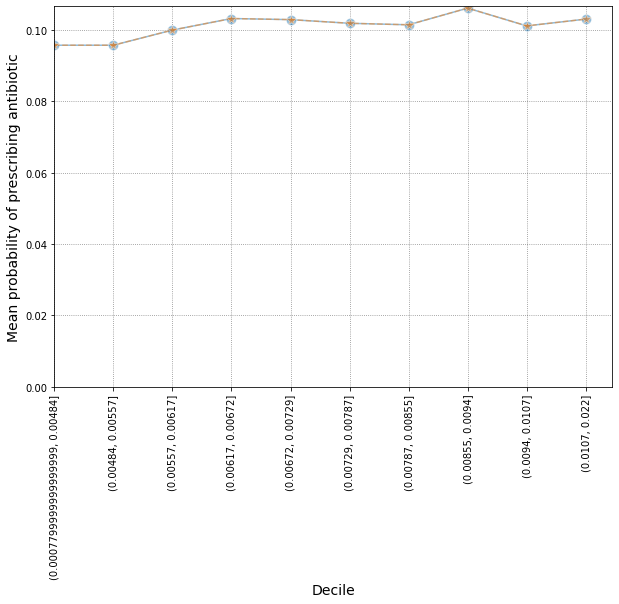


AUROC of LR for deciles with development and validation data: 0.50999 and 0.49703
AUROC of RF for deciles with development and validation data: 0.52605 and 0.49930
LR coefficients:
                                              OR  Lower CI  Upper CI
bins_(0.0007799999999999999, 0.00484]  0.102669  0.093297  0.112982
bins_(0.00484, 0.00557]                0.109117  0.099306  0.119898
bins_(0.00557, 0.00617]                0.110871  0.100960  0.121755
bins_(0.00617, 0.00672]                0.115047  0.104864  0.126220
bins_(0.00672, 0.00729]                0.115596  0.105308  0.126890
bins_(0.00729, 0.00787]                0.114387  0.104162  0.125617
bins_(0.00787, 0.00855]                0.118251  0.107645  0.129902
bins_(0.00855, 0.0094]                 0.115327  0.104873  0.126823
bins_(0.0094, 0.0107]                  0.113651  0.103253  0.125096
bins_(0.0107, 0.022]                   0.116226  0.105500  0.128043
antibacterial_brit                     0.995652  0.975377  1.016348



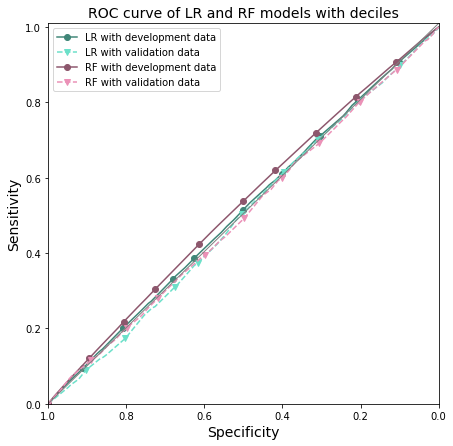

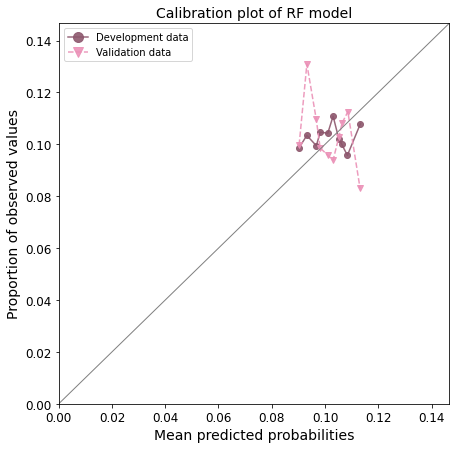

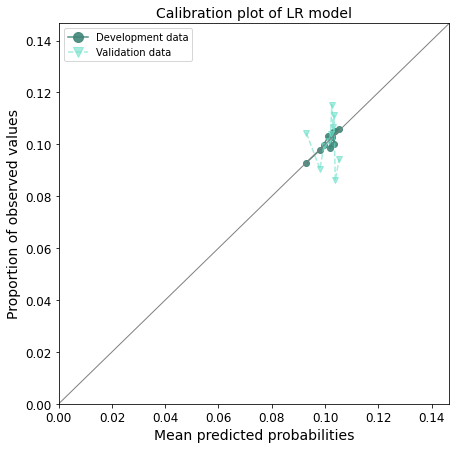

In [54]:
#build cox model for hosp prediction using non ab users' data
prob_pred_cough_no_abs_incdt_post_2nd_lockdown, prob_pred_cough_no_abs_incdt_post_2nd_lockdown_bin = cox_build('cough', 'incdt_post_2nd_lockdown', data_cough_incdt_post_2nd_lockdown, data_cough_no_abs_incdt_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('cough', 'incdt_post_2nd_lockdown', prob_pred_cough_no_abs_incdt_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('cough', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3434 total observations, 3412 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 3434
number of events observed = 22
   partial log-likelihood = -155.33
         time fit was run = 2023-06-28 22:22:50 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.03       0.97       0.62            -1.25             1.19                 0.29                 3.29
CCI_cat[T.medium]               -0.11       0.90       0.72            -1.52             1.30                 0.22                 3.67
CCI_cat[T.high]                  0.62       1.85       0.72            -0.80             2.04                 0.45                 7.67
CCI_cat[T.very_high]            -0.72       0.49       0.88            -2.45             1.02                 0.09                 2.77
age_cat[T.25_34]                -0.76       0.47       0.72            -2.16             0.65                 0.12                 1.91
age_cat[T.35_44]                -0.26       0.77       0.66            -1.56             1.04                 0.21                 2.82
age_cat[T.45_54]               -18.56       0.00    4508.32         -8854.70          8817.58                 0.00                  inf
age_cat[T.55_64]                -0.72       0.49       0.72            -2.13             0.69                 0.12                 1.99
age_cat[T.65_74]                -0.52       0.60       0.66            -1.81             0.78                 0.16                 2.18
age_cat[T.75_more]              -1.14       0.32       0.83            -2.76             0.48                 0.06                 1.61
antibacterial_brit               0.26       1.29       0.15            -0.03             0.54                 0.97                 1.72
bmi_cat[T.obese]                -0.11       0.89       0.78            -1.64             1.41                 0.19                 4.08
bmi_cat[T.overweight]           -1.22       0.30       1.24            -3.64             1.21                 0.03                 3.35
bmi_cat[T.underweight]           1.06       2.89       1.03            -0.96             3.08                 0.38                21.84
bmi_cat[T.unknown]              -0.39       0.68       0.85            -2.06             1.27                 0.13                 3.58
ethnicity[T.other]              -1.14       0.32       1.18            -3.45             1.18                 0.03                 3.24
ethnicity[T.unknown]            -0.25       0.78       0.69            -1.61             1.11                 0.20                 3.04
ethnicity[T.white]              -1.09       0.34       0.68            -2.41             0.24                 0.09                 1.27
flu_vaccine[T.yes]              -0.17       0.85       0.76            -1.65             1.32                 0.19                 3.74
imd[T.medium]                   18.20   8.04e+07    4221.84         -8256.46          8292.87                 0.00                  inf
imd[T.unaffluent]               18.40   9.83e+07    4221.84         -8256.26          8293.07                 0.00                  inf
imd[T.unknown]                  19.19   2.16e+08    4221.84         -8255.47          8293.85                 0.00                  inf
imd[T.very_affluent]            18.56   1.15e+08    4221.84         -8256.11          8293.22                 0.00                  inf
imd[T.very_unaffluent]          17.86   5.70e+07    4221.84         -8256.80          8292.52                 0.00                  inf
region[T.east_midlands]          0.40       1.49       0.92            

12322


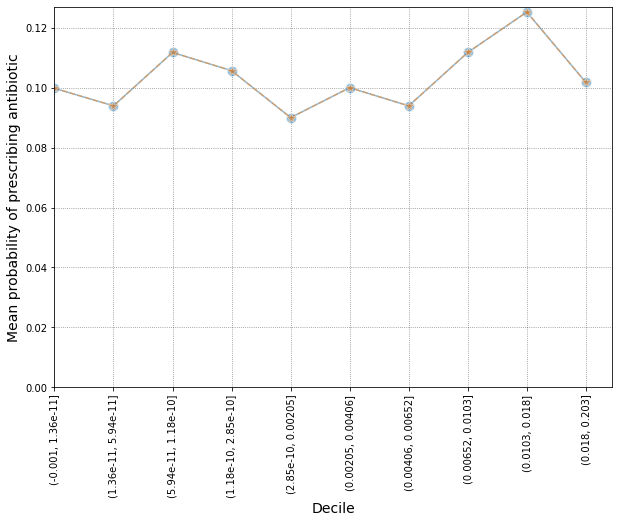


AUROC of LR for deciles with development and validation data: 0.54908 and 0.46422
AUROC of RF for deciles with development and validation data: 0.58587 and 0.47925
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(-0.001, 1.36e-11]    0.098688  0.068176  0.142856
bins_(0.00205, 0.00406]    0.117865  0.085309  0.162846
bins_(0.00406, 0.00652]    0.106084  0.074694  0.150667
bins_(0.00652, 0.0103]     0.121084  0.086788  0.168934
bins_(0.0103, 0.018]       0.137154  0.099038  0.189938
bins_(0.018, 0.203]        0.134997  0.096237  0.189368
bins_(1.18e-10, 2.85e-10]  0.116183  0.082292  0.164032
bins_(1.36e-11, 5.94e-11]  0.087893  0.060632  0.127412
bins_(2.85e-10, 0.00205]   0.076180  0.050350  0.115261
bins_(5.94e-11, 1.18e-10]  0.127047  0.092101  0.175253
antibacterial_brit         1.010972  0.936285  1.091618

RF feature importance:
                             rf_coef
antibacterial_brit         0.589362
bins_(2.85e-10, 0.00205]   0.070208
bins_(0.0103

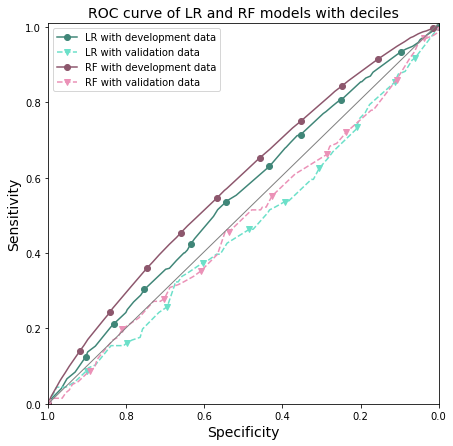

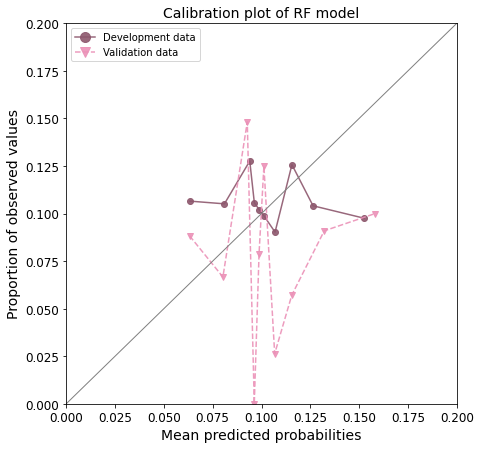

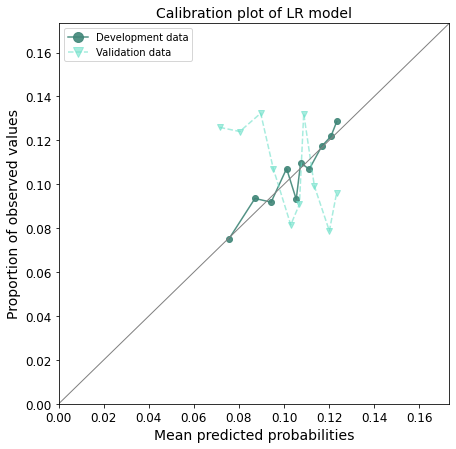

In [55]:
#build cox model for hosp prediction using non ab users' data
prob_pred_cough_no_abs_prevl_prepandemic, prob_pred_cough_no_abs_prevl_prepandemic_bin = cox_build('cough', 'prevl_prepandemic', data_cough_prevl_prepandemic, data_cough_no_abs_prevl_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('cough', 'prevl_prepandemic', prob_pred_cough_no_abs_prevl_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('cough', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)

<lifelines.CoxPHFitter: fitted with 3951 total observations, 3912 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 3951
number of events observed = 39
   partial log-likelihood = -305.70
         time fit was run = 2023-06-28 22:22:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.39       1.48       0.58            -0.74             1.52                 0.48                 4.56
CCI_cat[T.medium]                0.60       1.82       0.60            -0.59             1.78                 0.56                 5.95
CCI_cat[T.high]                  0.94       2.55       0.63            -0.30             2.17                 0.74                 8.78
CCI_cat[T.very_high]             0.38       1.47       0.65            -0.89             1.65                 0.41                 5.23
age_cat[T.25_34]                 0.46       1.59       0.53            -0.58             1.50                 0.56                 4.49
age_cat[T.35_44]                -0.02       0.98       0.58            -1.15             1.12                 0.32                 3.06
age_cat[T.45_54]                -0.10       0.90       0.61            -1.29             1.09                 0.27                 2.98
age_cat[T.55_64]                -0.09       0.91       0.61            -1.28             1.10                 0.28                 3.02
age_cat[T.65_74]                -0.62       0.54       0.71            -2.01             0.78                 0.13                 2.17
age_cat[T.75_more]              -0.12       0.89       0.61            -1.31             1.08                 0.27                 2.93
antibacterial_brit              -0.11       0.90       0.12            -0.35             0.13                 0.71                 1.13
bmi_cat[T.obese]                 0.65       1.91       0.74            -0.80             2.09                 0.45                 8.11
bmi_cat[T.overweight]            0.65       1.92       0.84            -1.00             2.30                 0.37                 9.99
bmi_cat[T.underweight]         -17.34       0.00    7114.53        -13961.56         13926.89                 0.00                  inf
bmi_cat[T.unknown]               0.30       1.35       0.79            -1.26             1.86                 0.28                 6.41
ethnicity[T.other]              18.48   1.06e+08    4232.17         -8276.42          8313.39                 0.00                  inf
ethnicity[T.unknown]            18.07   7.03e+07    4232.17         -8276.84          8312.97                 0.00                  inf
ethnicity[T.white]              17.61   4.43e+07    4232.17         -8277.30          8312.51                 0.00                  inf
flu_vaccine[T.yes]               0.01       1.01       0.53            -1.03             1.05                 0.36                 2.86
imd[T.medium]                    0.76       2.14       0.60            -0.42             1.95                 0.66                 7.00
imd[T.unaffluent]                0.41       1.50       0.65            -0.87             1.68                 0.42                 5.35
imd[T.unknown]                   0.64       1.90       0.87            -1.07             2.35                 0.34                10.49
imd[T.very_affluent]             0.77       2.15       0.61            -0.44             1.97                 0.64                 7.17
imd[T.very_unaffluent]           0.94       2.57       0.59            -0.22             2.11                 0.80                 8.24
region[T.east_midlands]          1.06       2.89       0.82            

12256


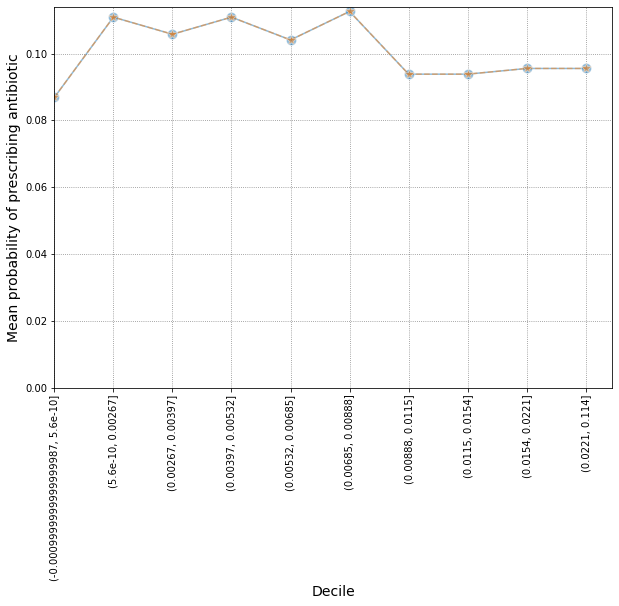


AUROC of LR for deciles with development and validation data: 0.53418 and 0.46389
AUROC of RF for deciles with development and validation data: 0.57990 and 0.48387
LR coefficients:
                                               OR  Lower CI  Upper CI
bins_(-0.0009999999999999987, 5.6e-10]  0.090536  0.063775  0.128527
bins_(0.00267, 0.00397]                 0.105197  0.075262  0.147040
bins_(0.00397, 0.00532]                 0.112651  0.081176  0.156332
bins_(0.00532, 0.00685]                 0.107791  0.077646  0.149638
bins_(0.00685, 0.00888]                 0.129244  0.095299  0.175278
bins_(0.00888, 0.0115]                  0.118878  0.086176  0.163991
bins_(0.0115, 0.0154]                   0.102342  0.073494  0.142515
bins_(0.0154, 0.0221]                   0.105274  0.075795  0.146218
bins_(0.0221, 0.114]                    0.104261  0.075490  0.143998
bins_(5.6e-10, 0.00267]                 0.149730  0.110456  0.202968
antibacterial_brit                      0.990631  0.923650

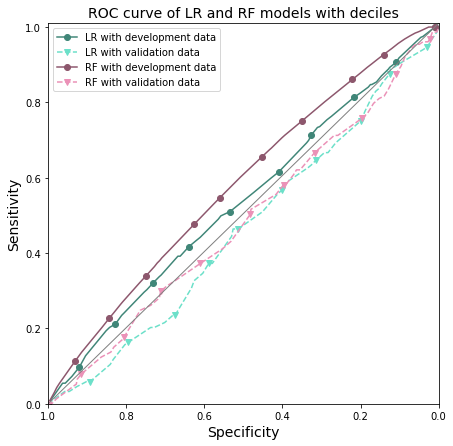

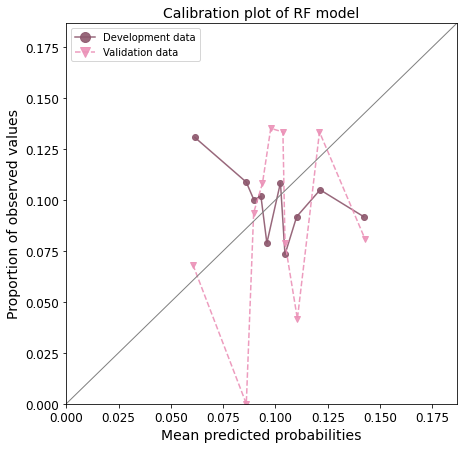

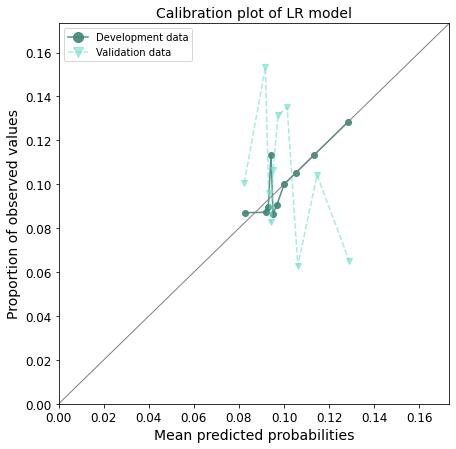

In [56]:
#build cox model for hosp prediction using non ab users' data
prob_pred_cough_no_abs_prevl_during_pandemic, prob_pred_cough_no_abs_prevl_during_pandemic_bin = cox_build('cough', 'prevl_during_pandemic', data_cough_prevl_during_pandemic, data_cough_no_abs_prevl_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('cough', 'prevl_during_pandemic', prob_pred_cough_no_abs_prevl_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('cough', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)

<lifelines.CoxPHFitter: fitted with 5144 total observations, 5103 right-censored observations>
             duration col = 'duration_cough_admitted'
                event col = 'event_cough_admitted'
      baseline estimation = breslow
   number of observations = 5144
number of events observed = 41
   partial log-likelihood = -327.89
         time fit was run = 2023-06-28 22:22:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.16       3.20       0.63            -0.07             2.40                 0.93                11.03
CCI_cat[T.medium]                0.88       2.41       0.68            -0.45             2.21                 0.64                 9.13
CCI_cat[T.high]                  0.71       2.04       0.82            -0.90             2.32                 0.41                10.15
CCI_cat[T.very_high]             1.51       4.55       0.65             0.23             2.80                 1.26                16.38
age_cat[T.25_34]                 0.52       1.69       0.63            -0.71             1.76                 0.49                 5.82
age_cat[T.35_44]                 0.71       2.04       0.62            -0.49             1.92                 0.61                 6.83
age_cat[T.45_54]                -0.02       0.98       0.71            -1.41             1.38                 0.24                 3.96
age_cat[T.55_64]                 0.62       1.87       0.63            -0.61             1.86                 0.54                 6.44
age_cat[T.65_74]                 0.38       1.46       0.68            -0.95             1.70                 0.39                 5.47
age_cat[T.75_more]               0.46       1.58       0.65            -0.82             1.73                 0.44                 5.66
antibacterial_brit              -0.04       0.96       0.11            -0.26             0.18                 0.77                 1.19
bmi_cat[T.obese]                 0.31       1.37       0.74            -1.14             1.77                 0.32                 5.87
bmi_cat[T.overweight]           -1.25       0.29       1.23            -3.66             1.15                 0.03                 3.17
bmi_cat[T.underweight]           1.14       3.13       0.92            -0.67             2.95                 0.51                19.06
bmi_cat[T.unknown]               0.54       1.71       0.77            -0.97             2.04                 0.38                 7.72
ethnicity[T.other]              -1.56       0.21       1.12            -3.77             0.64                 0.02                 1.90
ethnicity[T.unknown]            -0.01       0.99       0.58            -1.14             1.12                 0.32                 3.07
ethnicity[T.white]              -0.46       0.63       0.55            -1.54             0.62                 0.22                 1.85
flu_vaccine[T.yes]               0.15       1.16       0.48            -0.80             1.09                 0.45                 2.98
imd[T.medium]                   -0.41       0.66       0.49            -1.37             0.54                 0.25                 1.72
imd[T.unaffluent]               -1.32       0.27       0.65            -2.60            -0.04                 0.07                 0.96
imd[T.unknown]                  -1.11       0.33       1.05            -3.16             0.95                 0.04                 2.59
imd[T.very_affluent]            -0.11       0.90       0.44            -0.97             0.76                 0.38                 2.13
imd[T.very_unaffluent]          -0.19       0.83       0.46            -1.08             0.70                 0.34                 2.02
region[T.east_midlands]         -0.21       0.81       0.59            

12229


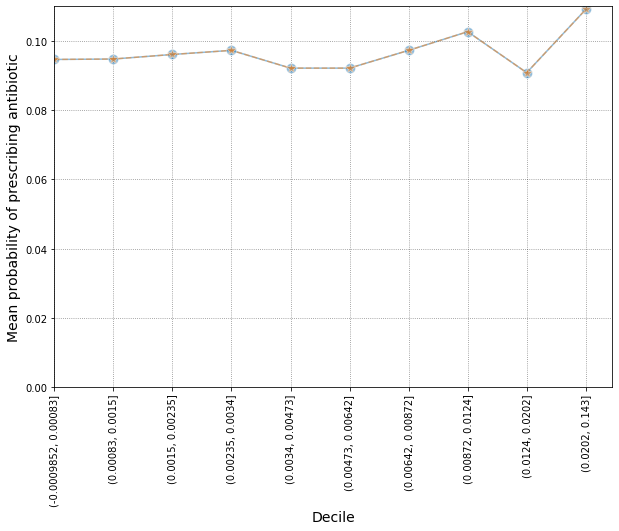


AUROC of LR for deciles with development and validation data: 0.52817 and 0.46468
AUROC of RF for deciles with development and validation data: 0.57735 and 0.46493
LR coefficients:
                                   OR  Lower CI  Upper CI
bins_(-0.0009852, 0.00083]  0.115441  0.086911  0.153336
bins_(0.00083, 0.0015]      0.110123  0.082726  0.146592
bins_(0.0015, 0.00235]      0.091913  0.067760  0.124674
bins_(0.00235, 0.0034]      0.090288  0.066446  0.122685
bins_(0.0034, 0.00473]      0.094543  0.069431  0.128737
bins_(0.00473, 0.00642]     0.089225  0.065411  0.121708
bins_(0.00642, 0.00872]     0.094051  0.069952  0.126452
bins_(0.00872, 0.0124]      0.104457  0.078223  0.139490
bins_(0.0124, 0.0202]       0.094683  0.069851  0.128344
bins_(0.0202, 0.143]        0.118483  0.090101  0.155806
antibacterial_brit          1.005325  0.943761  1.070906

RF feature importance:
                              rf_coef
antibacterial_brit          0.604389
bins_(0.0202, 0.143]        0.0563

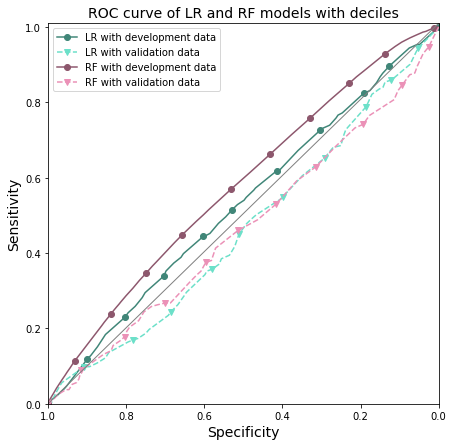

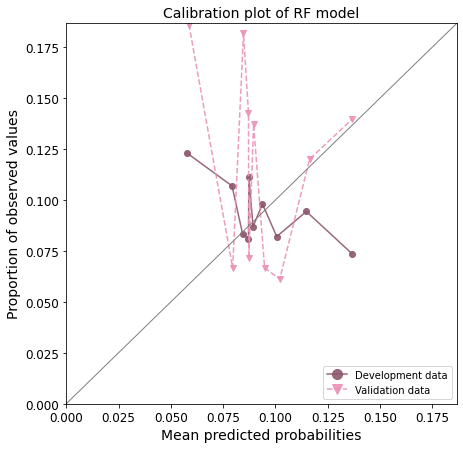

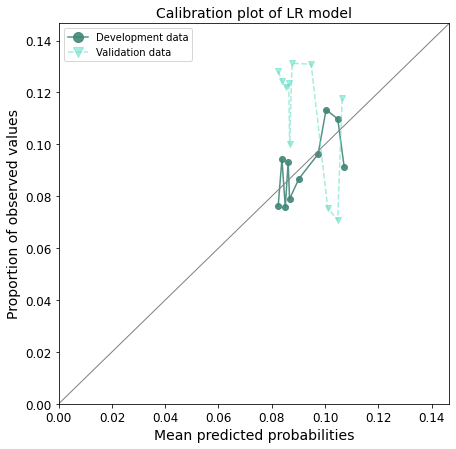

In [57]:
#build cox model for hosp prediction using non ab users' data
prob_pred_cough_no_abs_prevl_post_2nd_lockdown, prob_pred_cough_no_abs_prevl_post_2nd_lockdown_bin = cox_build('cough', 'prevl_post_2nd_lockdown', data_cough_prevl_post_2nd_lockdown, data_cough_no_abs_prevl_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('cough', 'prevl_post_2nd_lockdown', prob_pred_cough_no_abs_prevl_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('cough', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)